In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_excel('online_retail_II.xlsx')


In [4]:
df.shape

(525461, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [7]:
df[['Quantity', 'Price']].describe()

,Quantity,Price
count,525461.000000,525461.000000
mean,10.337667,4.688834
std,107.424110,146.126914
min,-9600.000000,-53594.360000
25%,1.000000,1.250000
50%,3.000000,2.100000
75%,10.000000,4.210000
max,19152.000000,25111.090000


In [8]:
df['Customer ID'].nunique() # number of customers

4383

In [10]:
df['StockCode'].nunique() # number of products

4632

## Cleaning Data


### Removing null Customer IDs

In [5]:
df.drop(index = df[df['Customer ID'].isna()].index, inplace = True)

### Changing the datatype of r, f, m columns

In [13]:
rfm['r'] = pd.to_numeric(rfm['r'])
rfm['f'] = pd.to_numeric(rfm['f'])
rfm['m'] = pd.to_numeric(rfm['m'])

## Adding columns

### 1: Adding the total number of purchases per customer

In [6]:
purchase_counts = df.groupby('Customer ID')['Invoice'].count()
df['Purchase Counts'] = df['Customer ID'].map(purchase_counts)

### 2: Adding recency column

In [7]:
cur_date = pd.to_datetime('2010-12-30 20:01:00')
df['Recency'] = (cur_date - df['InvoiceDate']).dt.days


### 3: Changing data type of date column

In [8]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

### 2: Total Amount spent by each customer

In [9]:
df['Total'] = df['Quantity'] * df['Price']

In [10]:
total_spent = df.groupby('Customer ID')['Total'].sum()
df['Total Spent'] = df['Customer ID'].map(total_spent)

In [11]:
df.loc[df['Total Spent'] < 0, 'Total Spent'] = 0

### 3: Making a new Data Frame to segment every customer

In [12]:
rfm = pd.DataFrame()
rfm['r'] = pd.qcut(df.groupby('Customer ID')['Recency'].min(), 5, labels = [5, 4, 3, 2, 1])
rfm['f'] = pd.qcut(df.groupby('Customer ID')['Invoice'].count(), 5, labels = [1, 2, 3, 4, 5])
rfm['m'] = pd.qcut(df.groupby('Customer ID')['Total'].sum(), 5, labels = [1, 2, 3, 4, 5])

In [14]:
rfm['RFM Score'] = rfm['r'] + rfm['f'] + rfm['m']
rfm.head()

,r,f,m,RFM Score
Customer ID,,,,
12346.0,3,3,1,7
12347.0,5,4,4,13
12348.0,2,2,1,5
12349.0,3,4,5,12
12351.0,5,2,2,9


## 4: Adding week number column

In [15]:
df['Day Name'] = df['InvoiceDate'].dt.day_name()

## Question 1: How many customers fall into each segment (Champions, Loyal, At-Risk, Lost)?

In [16]:
def segmentation(rfm):
    if rfm['RFM Score'] >= 12:
        return 'Champion'
    elif rfm['RFM Score'] >= 8:
        return 'Loyal'
    elif rfm['RFM Score'] >= 4:
        return 'At Risk'
    else:
        return 'Lost'
rfm['Segment'] = rfm.apply(segmentation, axis = 1)

In [17]:
rfm['Segment'].value_counts()

Segment
Loyal       1462
At Risk     1375
Champion    1263
Lost         283
Name: count, dtype: int64

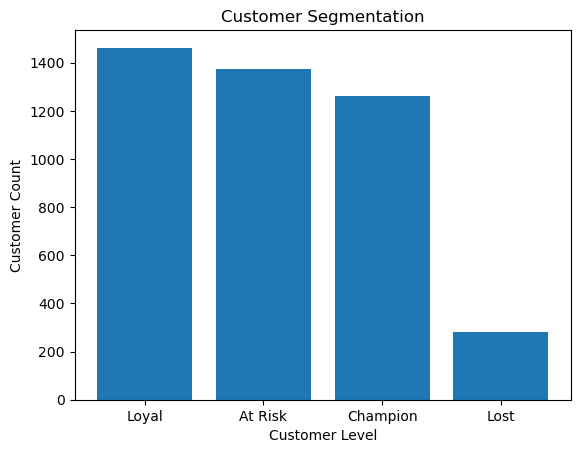

In [18]:
plt.bar(rfm['Segment'].value_counts().index, rfm['Segment'].value_counts().values)
plt.title('Customer Segmentation')
plt.xlabel('Customer Level')
plt.ylabel('Customer Count')
plt.show()

## Question 2: Who are the top 20 customers by total revenue? What percentage of total revenue do the top 10% of customers generate?

In [19]:
df.groupby('Customer ID')['Total Spent'].max().nlargest(20) # Top 20 Customers


Customer ID
18102.0    341776.73
14646.0    243853.05
14156.0    183180.55
14911.0    137675.91
13694.0    128172.42
17511.0     83760.60
15061.0     82162.74
16684.0     75610.17
13089.0     55828.31
16754.0     54558.18
15311.0     54093.73
17850.0     50414.50
13093.0     46332.26
17949.0     46144.75
17450.0     46097.22
16029.0     40808.30
15838.0     40053.35
14298.0     39626.87
12931.0     37836.86
13798.0     37222.05
Name: Total Spent, dtype: float64

In [20]:
top20_sum = df.groupby('Customer ID')['Total Spent'].max().nlargest(20).sum()
all_sum = df.groupby('Customer ID')['Total Spent'].max().sum()

Text(0.5, 1.0, 'Top 20 Customers Revenure Contribution VS Other')

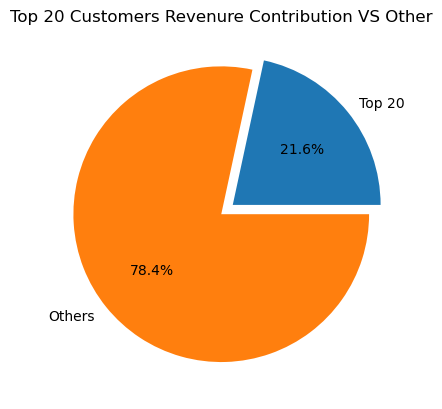

In [21]:
values = [top20_sum, all_sum - top20_sum]
plt.pie(values, labels = ['Top 20', 'Others'], explode = (0.1, 0), autopct = '%1.1f%%')
plt.title('Top 20 Customers Revenure Contribution VS Other')


## Question 3: How many customers have pruchased in the last 3 months, 6 months, 9 months?


In [24]:
customers = df.groupby('Customer ID')['Recency'].max()

df_customers = pd.DataFrame(customers)

def last_purchase(data):
    if data > 274:
        return '9+ months'
    elif data > 183:
        return '6-9 months'
    elif data > 91:
        return '3-6 months'
    else:
        return '<3 months'
df_customers['Last Purchased'] = customers.apply(last_purchase)

In [26]:
df_customers['Last Purchased'].value_counts()

Last Purchased
9+ months     2221
6-9 months     819
<3 months      769
3-6 months     574
Name: count, dtype: int64

Text(0, 0.5, 'Number Of Customers')

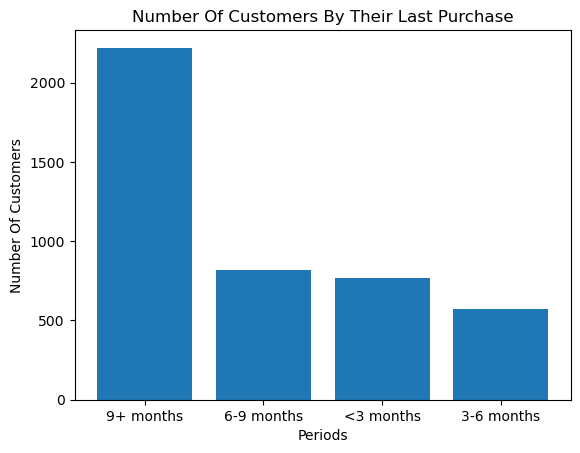

In [27]:
plt.bar(df_customers['Last Purchased'].value_counts().index, df_customers['Last Purchased'].value_counts().values)
plt.title('Number Of Customers By Their Last Purchase')
plt.xlabel('Periods')
plt.ylabel('Number Of Customers')

## Question 4: Find out the number of churned customers (6+ months of inactivity)

In [28]:
total_customers = len(df['Customer ID'].unique())
churned_customers = df_customers[df_customers['Last Purchased'].isin(['6-9 months', '9+ months'])].shape[0] # Number of churned customers

<function matplotlib.pyplot.show(close=None, block=None)>

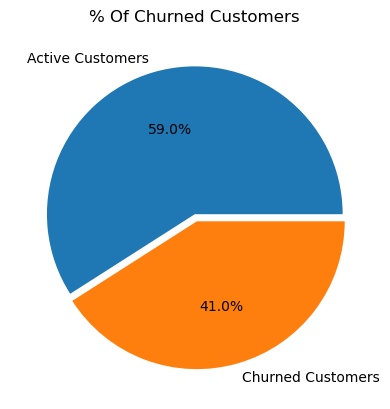

In [33]:
churn_data = [total_customers, churned_customers]
plt.pie(churn_data, labels=['Active Customers', 'Churned Customers'], explode = [0, 0.05], autopct = '%1.1f%%')
plt.title('% Of Churned Customers')
plt.show

## Question 5: What are the top 20 Products by revenue? And how much percent of profits do they contribute?

In [34]:
top_20_prod = df.groupby(['StockCode', 'Description'])['Total'].sum().sort_values(ascending=False).head(20) # Top 20 Products
top_20_prod

StockCode  Description                        
85123A     WHITE HANGING HEART T-LIGHT HOLDER     148876.66
22423      REGENCY CAKESTAND 3 TIER               136866.30
84879      ASSORTED COLOUR BIRD ORNAMENT           69854.96
85099B     JUMBO BAG RED RETROSPOT                 51608.40
POST       POSTAGE                                 45520.86
84347      ROTATING SILVER ANGELS T-LIGHT HLDR     39902.10
22086      PAPER CHAIN KIT 50'S CHRISTMAS          36866.45
47566      PARTY BUNTING                           34998.70
85099F     JUMBO BAG STRAWBERRY                    33893.70
21621      VINTAGE UNION JACK BUNTING              33546.96
15056N     EDWARDIAN PARASOL NATURAL               33541.65
15056BL    EDWARDIAN PARASOL BLACK                 31038.70
22189      CREAM HEART CARD HOLDER                 29774.59
85099C     JUMBO  BAG BAROQUE BLACK WHITE          29433.30
21232      STRAWBERRY CERAMIC TRINKET BOX          29117.88
21623      VINTAGE UNION JACK MEMOBOARD            28

<Axes: xlabel='StockCode,Description'>

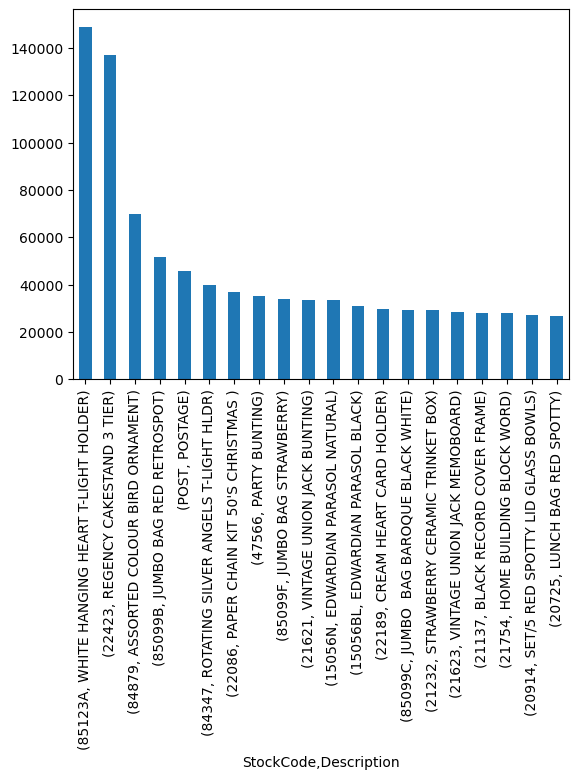

In [35]:
top_20_prod.plot(kind = 'bar')

In [36]:
top_20_revenue = top_20_prod.sum()
tot_revenue = df['Total'].sum()

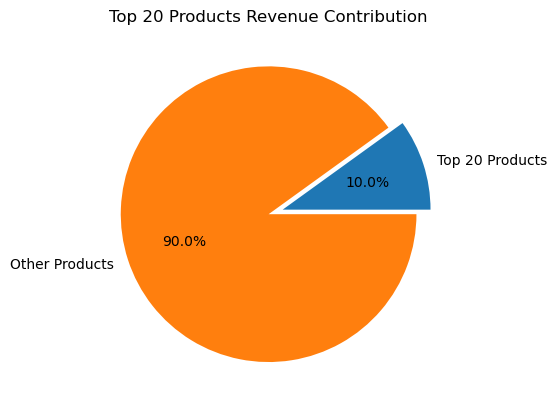

In [37]:
plt.pie([top_20_revenue, tot_revenue], autopct = '%1.1f%%', labels = ['Top 20 Products', 'Other Products'], explode = [0.1, 0])
plt.title('Top 20 Products Revenue Contribution')
plt.show()

## Question 6: Which day of the week are sales the highest?

In [38]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_sales = df.groupby('Day Name')['Invoice'].count()
weekly_sales.index = pd.Categorical(weekly_sales.index, categories=weekday_order, ordered=True)
weekly_sales

Friday       52216
Monday       64852
Saturday       400
Sunday       74188
Thursday     83912
Tuesday      72711
Wednesday    69255
Name: Invoice, dtype: int64

<Axes: >

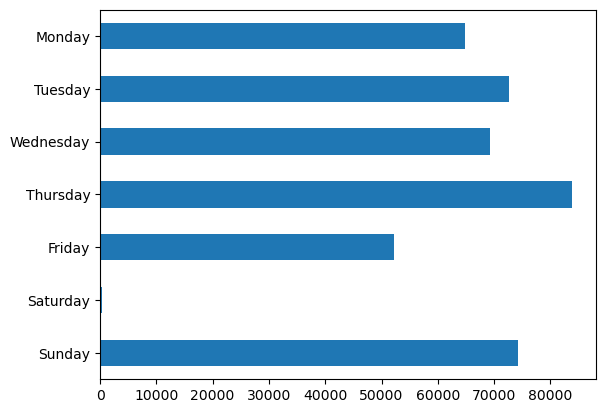

In [39]:
weekly_sales.sort_index(ascending=False).plot(kind='barh')